# Naive Bayes

This is to filter spams based on the multinomial Naive Bayes algorithm

### Reference

 [Kaggle Notebook: Natural Language Processing (NLP) for Beginners](https://www.kaggle.com/code/faressayah/natural-language-processing-nlp-for-beginners#%F0%9F%94%8D-Exploratory-Data-Analysis-(EDA)) <br>
 [Spam Filter in Python: Naive Bayes from Scratch](https://www.kdnuggets.com/2020/07/spam-filter-python-naive-bayes-scratch.html) <br>
 [Naive Bayes, Clearly Explained!!!](https://www.youtube.com/watch?v=O2L2Uv9pdDA&t=269s) <br>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

In [2]:
def read_sample_data(path):
    df_sms = pd.read_csv(path, encoding='latin-1')
    df_sms.dropna(how="any", inplace=True, axis=1)
    df_sms.columns = ['label', 'message']
    return df_sms
    
df_sms = read_sample_data('../data/sample/spam.csv')
# df_sms.head()
# df_sms.describe()
# df_sms.groupby('label').describe()

# convert label to a numerical variable
df_sms['label_num'] = df_sms.label.map({'ham':0, 'spam':1})
df_sms['message_len'] = df_sms.message.apply(len)
df_sms.head()

,label,message,label_num,message_len
0,ham,"Go until jurong point, crazy.. Available only ...",0,111
1,ham,Ok lar... Joking wif u oni...,0,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
3,ham,U dun say so early hor... U c already then say...,0,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61


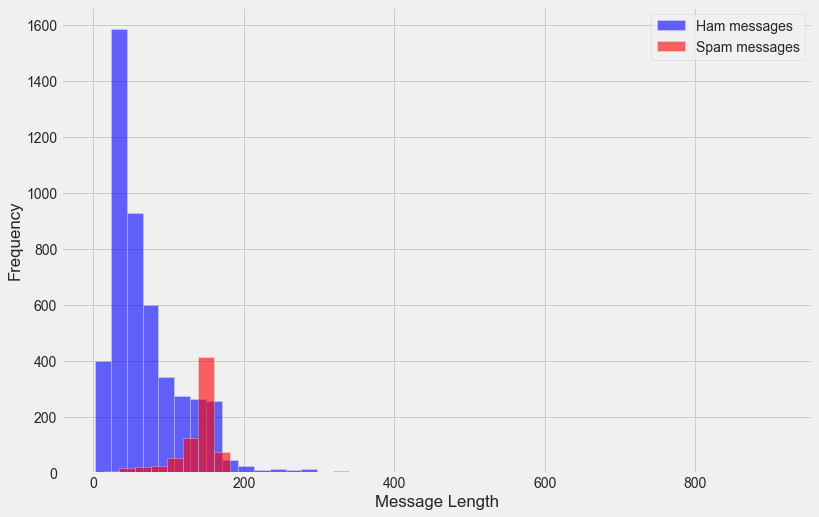

In [3]:
plt.figure(figsize=(12, 8))
df_sms[df_sms.label=='ham' ].message_len.plot(bins=43, kind='hist', color='blue', label='Ham messages', alpha=0.6)
df_sms[df_sms.label=='spam'].message_len.plot(         kind='hist', color='red', label='Spam messages', alpha=0.6)
plt.xlabel("Message Length")
plt.legend()

In [4]:
df_sms[df_sms.label=='ham'].describe()
df_sms[df_sms.message_len == 910]['message'].iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

# 불용어 제거 (stop word 제거)

갖고 있는 데이터에서 유의미한 단어 토큰만을 선별하기 위해서는 큰 의미가 없는 단어 토큰을 제거하는 작업이 필요합니다. 여기서 큰 의미가 없다라는 것은 자주 등장하지만 분석을 하는 것에 있어서는 큰 도움이 되지 않는 단어들을 말합니다. 예를 들면, I, my, me, over, 조사, 접미사 같은 단어들은 문장에서는 자주 등장하지만 실제 의미 분석을 하는데는 거의 기여하는 바가 없는 경우가 있습니다. 이러한 단어들을 **불용어(stopword)**라고 하며, NLTK에서는 위와 같은 100여개 이상의 영어 단어들을 불용어로 패키지 내에서 미리 정의하고 있습니다. [출처: 딥러닝을 위한 자연어 처리 입문](https://wikidocs.net/22530)

In [5]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string

def text_process(msg):
    STOPWORDS = stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure']
    # 1. 철자 단위 검사 후 문장부호(punctuation) 제거
    nopunc = [character for character in msg if character not in string.punctuation]
    nopunc = ''.join(nopunc)
    # 2. 불용어(stop word) 제거
    return ' '.join([word for word in nopunc.split() if word.lower() not in STOPWORDS])

text_process('Here\'s my example sentence. Hello, world~! How are u?')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hwang\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


'Heres example sentence Hello world'

In [6]:
# 'message' 열에서 불용어를 제거하여 'clean_message' 라는 이름의 컬럼을 새로 만든다.
df_sms['clean_message'] = df_sms.message.apply(text_process)
df_sms['clean_message'] = df_sms['clean_message'].str.lower()
df_sms['label'].value_counts(normalize=True)
df_sms.head()

,label,message,label_num,message_len,clean_message
0,ham,"Go until jurong point, crazy.. Available only ...",0,111,go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,0,29,ok lar joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,free entry wkly comp win fa cup final tkts 21s...
3,ham,U dun say so early hor... U c already then say...,0,49,dun say early hor c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61,nah think goes usf lives around though


# Naive Bayes 모델을 이용한 스팸 Detector

Naive Bayes https://www.kdnuggets.com/2020/07/spam-filter-python-naive-bayes-scratch.html

In [7]:
# 랜덤하게 선택된 데이타셋 
data_randomized = df_sms.sample(frac=1, random_state=1)

# 학습, 테스트 데이타 비율 0.8:0.2 로 하기 위해서 데이타의 순서에 따라 처음 80% Train 데이타 셋에 할당. 나머지는 테스트 데이타 셋
training_test_index = round(len(data_randomized) * 0.8)

# 학습 데이타와 테스트 데이타를 구함
training_set = data_randomized[:training_test_index].reset_index(drop=True)
test_set = data_randomized[training_test_index:].reset_index(drop=True)

print(training_set.shape)
print(test_set.shape)
print(training_set.head())
print(test_set.head())

(4458, 5)
(1114, 5)
  label                                            message  label_num  \
0   ham                           Convey my regards to him          0   
1   ham           [Û_] anyway, many good evenings to u! s          0   
2   ham  My sort code is  and acc no is . The bank is n...          0   
3   ham                        Sorry i din lock my keypad.          0   
4  spam  Hi babe its Chloe, how r u? I was smashed on s...          1   

   message_len                                      clean_message  
0           24                                     convey regards  
1           40                       û anyway many good evenings  
2          114  sort code acc bank natwest reply confirm ive s...  
3           27                              sorry din lock keypad  
4          160  hi babe chloe r smashed saturday night great w...  
  label                                            message  label_num  \
0   ham  S...from the training manual it show there is ...  

In [8]:
# 해당 메세지의 단어들을 모음

training_set['split_wd'] = training_set['clean_message'].str.split()

vocabulary = []
for sms in training_set['split_wd']:
   for word in sms:
      vocabulary.append(word)

vocabulary = list(set(vocabulary))

# len(vocabulary)
# print(training_set['split_wd'])

In [9]:
word_counts_per_sms = {unique_word: [0] * len(training_set['split_wd']) for unique_word in vocabulary}

for index, sms in enumerate(training_set['split_wd']):
   for word in sms:
      word_counts_per_sms[word][index] += 1
        
word_counts = pd.DataFrame(word_counts_per_sms)
word_counts.head()

training_set_clean = pd.concat([training_set, word_counts], axis=1)
training_set_clean.head()
training_set_clean = pd.concat([training_set, word_counts], axis=1)
training_set_clean.head()

,label,message,label_num,message_len,clean_message,split_wd,quickly,apps,xy,cheating,...,zeros,loyal,genus,masters,exchanged,housing,lovingly,soul,gaps,received
0,ham,Convey my regards to him,0,24,convey regards,"[convey, regards]",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,"[Û_] anyway, many good evenings to u! s",0,40,û anyway many good evenings,"[û, anyway, many, good, evenings]",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ham,My sort code is and acc no is . The bank is n...,0,114,sort code acc bank natwest reply confirm ive s...,"[sort, code, acc, bank, natwest, reply, confir...",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,Sorry i din lock my keypad.,0,27,sorry din lock keypad,"[sorry, din, lock, keypad]",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,spam,"Hi babe its Chloe, how r u? I was smashed on s...",1,160,hi babe chloe r smashed saturday night great w...,"[hi, babe, chloe, r, smashed, saturday, night,...",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# 스팸과 햄 메세지 구분하기
spam_messages = training_set_clean[training_set_clean['label'] == 'spam']
ham_messages = training_set_clean[training_set_clean['label'] == 'ham']

# P(Spam) and P(Ham) ; 전체 학습데이타에서 스팸메세지 비율과 햄메세지 비율 구하기
p_spam = len(spam_messages) / len(training_set_clean)
p_ham = len(ham_messages) / len(training_set_clean)

# N_Spam
n_words_per_spam_message = spam_messages['split_wd'].apply(len)
n_spam = n_words_per_spam_message.sum()

# N_Ham
n_words_per_ham_message = ham_messages['split_wd'].apply(len)
n_ham = n_words_per_ham_message.sum()

# N_Vocabulary
n_vocabulary = len(vocabulary)

# Laplace smoothing
alpha = 1

# print (n_words_per_spam_message)
print (n_spam)

9625


In [11]:
# Add the following since message label name needs to be unique to avoid any conflicts between this one and word
spam_messages.columns.values[1] = "original_message"
ham_messages.columns.values[1] = "original_message"
print (spam_messages)

     label                                   original_message  label_num  \
4     spam  Hi babe its Chloe, how r u? I was smashed on s...          1   
44    spam  3 FREE TAROT TEXTS! Find out about your love l...          1   
60    spam  Free 1st week entry 2 TEXTPOD 4 a chance 2 win...          1   
62    spam  ree entry in 2 a weekly comp for a chance to w...          1   
70    spam  SMS AUCTION - A BRAND NEW Nokia 7250 is up 4 a...          1   
...    ...                                                ...        ...   
4422  spam  Mila, age23, blonde, new in UK. I look sex wit...          1   
4423  spam  Todays Vodafone numbers ending with 4882 are s...          1   
4427  spam  Camera - You are awarded a SiPix Digital Camer...          1   
4434  spam  You will recieve your tone within the next 24h...          1   
4440  spam  complimentary 4 STAR Ibiza Holiday or å£10,000...          1   

      message_len                                      clean_message  \
4             1

In [12]:
# Initiate parameters
parameters_spam = {unique_word:0 for unique_word in vocabulary}
parameters_ham = {unique_word:0 for unique_word in vocabulary}

# Calculate parameters
# 모든 단어들의 spam 혹은 ham에서의 확률값 Histogram 을 구한다. 참고적으로 alpha = 1 를 두어서 확률 0을 막는다. (훈련 set에 없는 단어 처리?)
for word in vocabulary:
   n_word_given_spam = spam_messages[word].sum() # spam_messages already defined
   p_word_given_spam = (n_word_given_spam + alpha) / (n_spam + alpha*n_vocabulary)
   parameters_spam[word] = p_word_given_spam

   n_word_given_ham = ham_messages[word].sum() # ham_messages already defined
   p_word_given_ham = (n_word_given_ham + alpha) / (n_ham + alpha*n_vocabulary)
   parameters_ham[word] = p_word_given_ham

In [13]:
import re

def classify(message):
   '''
   message: a string
   '''

   message = re.sub('\W', ' ', message)
   message = message.lower().split()

   p_spam_given_message = p_spam
   p_ham_given_message = p_ham

   for word in message:
      if word in parameters_spam:
         p_spam_given_message *= parameters_spam[word]

      if word in parameters_ham: 
         p_ham_given_message *= parameters_ham[word]

   print('P(Spam|message):', p_spam_given_message)
   print('P(Ham|message):', p_ham_given_message)

   if p_ham_given_message > p_spam_given_message:
      print('Label: Ham')
   elif p_ham_given_message < p_spam_given_message:
      print('Label: Spam')
   else:
      print('Equal proabilities, have a human classify this!')

In [14]:
classify('WINNER!! This is the secret code to unlock the money: C3421.')
classify('This App is the fastest and easiest way stay updated with the latest news in South Korea.')

P(Spam|message): 9.688952036516804e-15
P(Ham|message): 2.173542202208541e-16
Label: Spam
P(Spam|message): 8.261148504048521e-32
P(Ham|message): 1.845921556903762e-31
Label: Ham


In [16]:
def classify_test_set(message):
   '''
   message: a string
   '''

   message = re.sub('\W', ' ', message)
   message = message.lower().split()

   p_spam_given_message = p_spam
   p_ham_given_message = p_ham

   for word in message:
      if word in parameters_spam:
         p_spam_given_message *= parameters_spam[word]

      if word in parameters_ham:
         p_ham_given_message *= parameters_ham[word]

   if p_ham_given_message > p_spam_given_message:
      return 'ham'
   elif p_spam_given_message > p_ham_given_message:
      return 'spam'
   else:
      return 'needs human classification'

In [17]:
test_set['predicted'] = test_set['clean_message'].apply(classify_test_set)
test_set.head()

,label,message,label_num,message_len,clean_message,predicted
0,ham,S...from the training manual it show there is ...,0,113,sfrom training manual show tech processits pas...,ham
1,spam,Do you want a new Video phone? 600 anytime any...,1,157,want new video phone 600 anytime network mins ...,spam
2,ham,True. Its easier with her here.,0,31,true easier,ham
3,ham,Midnight at the earliest,0,24,midnight earliest,ham
4,ham,"All done, all handed in. Don't know if mega sh...",0,104,done handed know mega shop asda counts celebra...,ham


In [18]:
correct = 0
total = test_set.shape[0]

for row in test_set.iterrows():
   row = row[1]
   if row['label'] == row['predicted']:
      correct += 1

print('Correct:', correct)
print('Incorrect:', total - correct)
print('Accuracy:', correct/total)

Correct: 1102
Incorrect: 12
Accuracy: 0.9892280071813285


# 모델 저장

### 스팸과 햄메일에 쓰인 단어들의 weight

In [20]:
import pickle
classifier = [p_spam, p_ham, parameters_spam, parameters_ham]
f = open('../models/nb_model.pickle', 'wb')
pickle.dump(classifier, f)
f.close()
print (classifier)

[0.13593539703903096, 0.8640646029609691, {'quickly': 5.578489345085351e-05, 'apps': 5.578489345085351e-05, 'xy': 5.578489345085351e-05, 'cheating': 5.578489345085351e-05, 'exeter': 5.578489345085351e-05, 'moral': 5.578489345085351e-05, 'rate': 0.0009483431886645096, 'geoenvironmental': 5.578489345085351e-05, 'sex': 0.0005578489345085351, '1148': 5.578489345085351e-05, '2end': 0.00016735468035256051, 'onlyfound': 5.578489345085351e-05, 'sum': 5.578489345085351e-05, 'printing': 5.578489345085351e-05, 'fave': 5.578489345085351e-05, 'brandy': 5.578489345085351e-05, 'filthy': 0.00016735468035256051, 'thrown': 5.578489345085351e-05, 'restocked': 5.578489345085351e-05, 'plz': 5.578489345085351e-05, 'starving': 5.578489345085351e-05, 'hdd': 5.578489345085351e-05, '40mph': 5.578489345085351e-05, 'boo': 5.578489345085351e-05, 'confidence': 5.578489345085351e-05, 'howz': 5.578489345085351e-05, 'janinexx': 0.00011156978690170702, '060505': 0.00011156978690170702, 'worryuse': 5.578489345085351e-05

# To Do 
초기 목적대로, 최소 accuracy 80% 를 달성하였다.

다음은 왜 12개가 잘못 분류되었는지 데이타를 찾아서 더 조사해보자. 그리고 알고리즘을 더 효과적으로 만들 수 있는지 알아보자.
Naive Bayes 는 훈련되지 않는 모르는 단어를 어떻게 다루었는지 체크해보자.
Naive Bayes 는 bag of words 를 쓰기 때문에, 단어의 순서에 관계없다.